In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

In [14]:
df = pd.read_csv('/Users/malwina.natkaniec/Downloads/ox_rev.csv')

In [15]:
df.head()

,ReportDay,SF_name,IS_NEW_PUB,MKT_DEM_SPEND_USD,MKT_PUB_REV_USD,OX_REVENUE,TOTAL_REQUESTS,MKT_REQUESTS,FILLS,MKT_IMPRESSIONS
0,2021-06-28,Automatad,False,672.562712,490.360576,182.202136,110839218,62063383.0,12157056.0,405852.0
1,2021-06-28,Mind Tank Media,False,1070.386924,846.429989,223.956935,75376144,55641408.0,17629858.0,357401.0
2,2021-06-28,Discovery NZ (Previously Mediaworks),False,26.216096,22.270789,3.945307,1687567,1269502.0,133579.0,18578.0
3,2021-06-28,United Online,False,867.309795,730.130310,137.179485,54361360,45836959.0,14674546.0,1299466.0
4,2021-06-28,Barstool Sports,False,2.741228,2.129037,0.612191,7934723,7192490.0,1740494.0,168.0


In [16]:
# df['ReportDay'].unique()

In [17]:
df_daily = df.groupby(["ReportDay"])["OX_REVENUE"].sum().reset_index()
df_daily.head()

,ReportDay,OX_REVENUE
0,2021-06-28,334611.349557
1,2021-06-29,337116.243923
2,2021-06-30,318582.769268
3,2021-07-01,259151.568894
4,2021-07-02,253966.165114


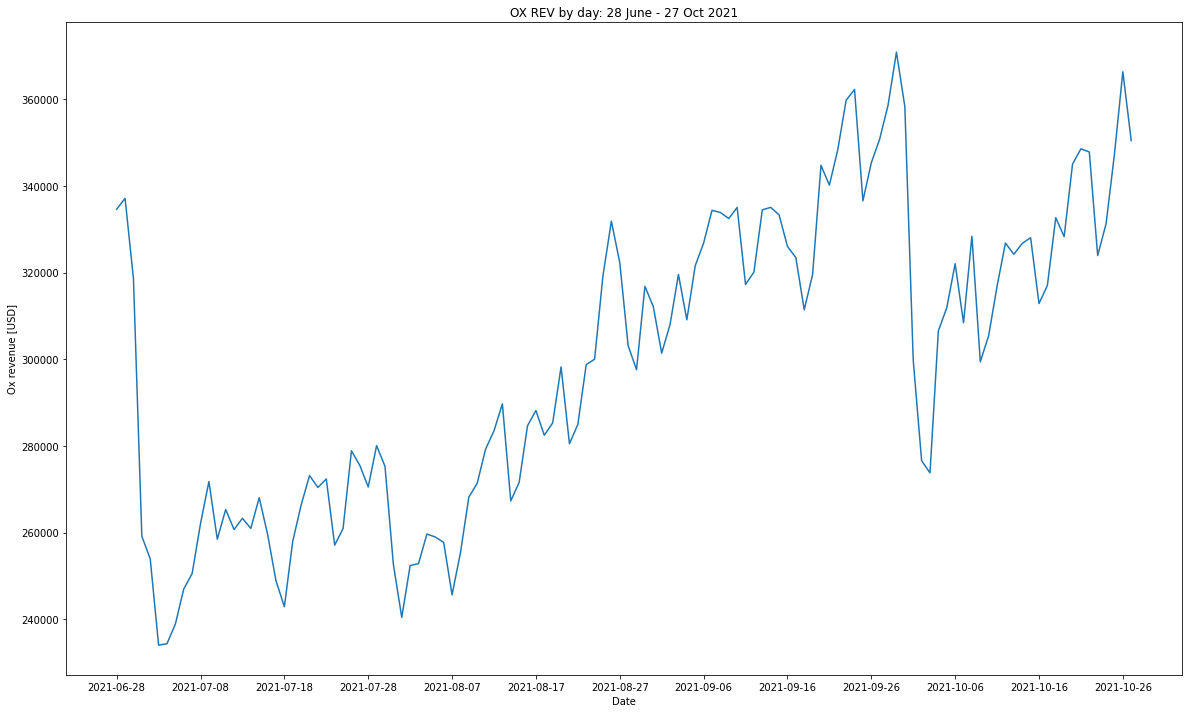

In [18]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)
max_xticks = 15
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)
plt.title("OX REV by day: 28 June - 27 Oct 2021")
plt.ylabel("Ox revenue [USD]")
plt.xlabel("Date")
plt.plot('ReportDay', "OX_REVENUE", data=df_daily)


(array([ 5.,  4., 16.,  9., 11.,  8.,  2.,  9.,  7., 15., 14.,  7.,  9.,
         3.,  3.]),
 array([234035.46338  , 243155.9200782, 252276.3767764, 261396.8334746,
        270517.2901728, 279637.746871 , 288758.2035692, 297878.6602674,
        306999.1169656, 316119.5736638, 325240.030362 , 334360.4870602,
        343480.9437584, 352601.4004566, 361721.8571548, 370842.313853 ]),
 <BarContainer object of 15 artists>)

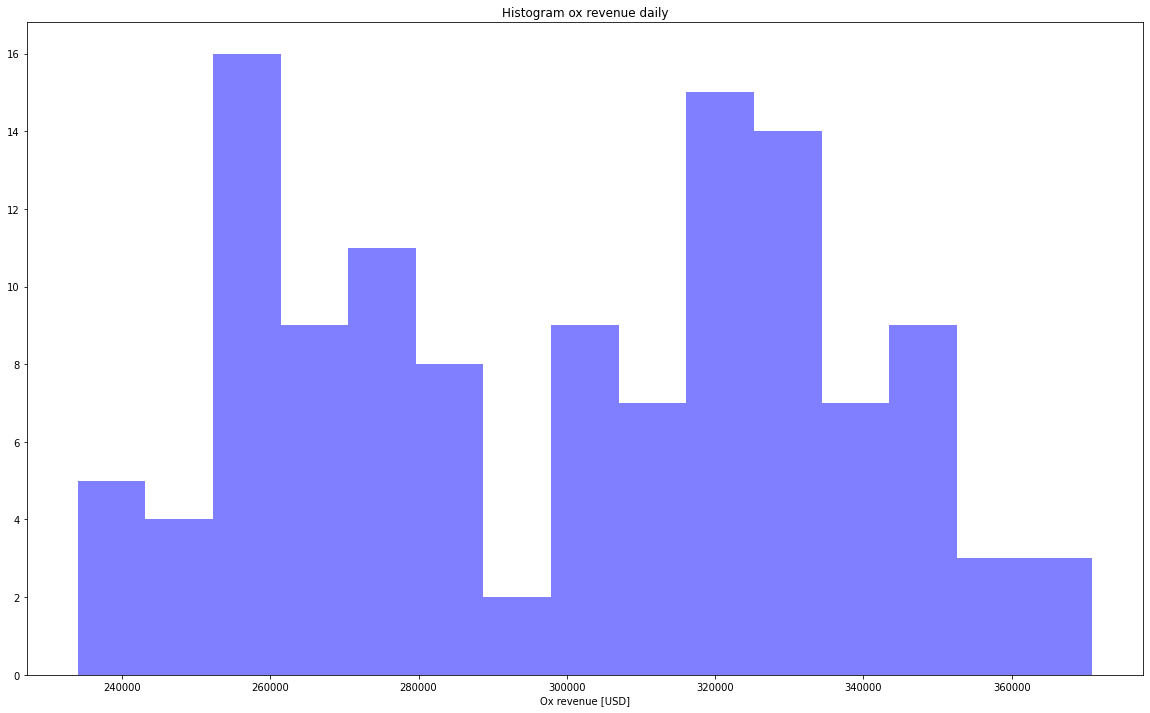

In [19]:
fig = plt.figure(figsize=(20, 12))
max_xticks = 15
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)
plt.title("Histogram ox revenue daily")

num_bins = 15

plt.xlabel("Ox revenue [USD]")
plt.hist(df_daily["OX_REVENUE"], num_bins, facecolor='blue', alpha=0.5)


In [20]:
df_sf = df.groupby(["SF_name"])["OX_REVENUE"].sum().reset_index()
df_sf.sort_values(["OX_REVENUE"] ,ascending=False).head()

,SF_name,OX_REVENUE
1434,Yahoo,2.152280e+06
771,Mediavine,1.326760e+06
1117,ShareThrough,1.018215e+06
975,Pluto TV,9.453127e+05
996,Primis,9.185304e+05


In [21]:
df_mediavine = df[df["SF_name"]=="Mediavine"]
df_mediavine = df_mediavine.groupby(["ReportDay"])["OX_REVENUE"].sum().reset_index()

df_yahoo = df[df["SF_name"]=="Yahoo"]
df_yahoo = df_yahoo.groupby(["ReportDay"])["OX_REVENUE"].sum().reset_index()

df_shareThrough= df[df["SF_name"]=="ShareThrough"]
df_shareThrough = df_shareThrough.groupby(["ReportDay"])["OX_REVENUE"].sum().reset_index()

df_shareThrough.head()

,ReportDay,OX_REVENUE
0,2021-06-28,6651.695334
1,2021-06-29,6667.156284
2,2021-06-30,6594.736892
3,2021-07-01,4763.655505
4,2021-07-02,5386.819396


Text(0.5, 0, 'Date')

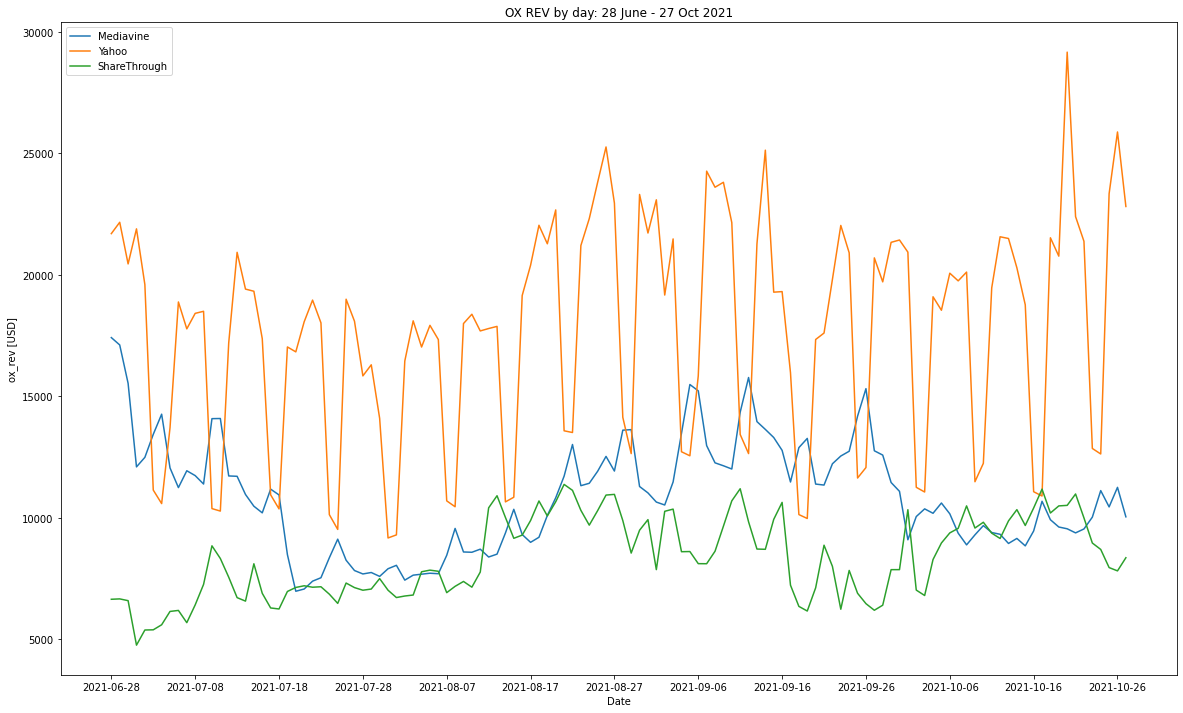

In [22]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)
ax.set_ylabel("ox_rev [USD]")
# ax2=ax.twinx()
# ax2.set_ylabel("OX_rev taotl [USD]",color="blue",fontsize=14)
max_xticks = 15
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)

ax.plot('ReportDay', "OX_REVENUE", data=df_mediavine, label="Mediavine")
ax.plot('ReportDay', "OX_REVENUE", data=df_yahoo, label="Yahoo")
ax.plot('ReportDay', "OX_REVENUE", data=df_shareThrough, label="ShareThrough")

plt.legend()
plt.title("OX REV by day: 28 June - 27 Oct 2021")
# plt.ylabel("Ox revenue [USD]")
plt.xlabel("Date")

Text(0.5, 0, 'Ox revenue [USD]')

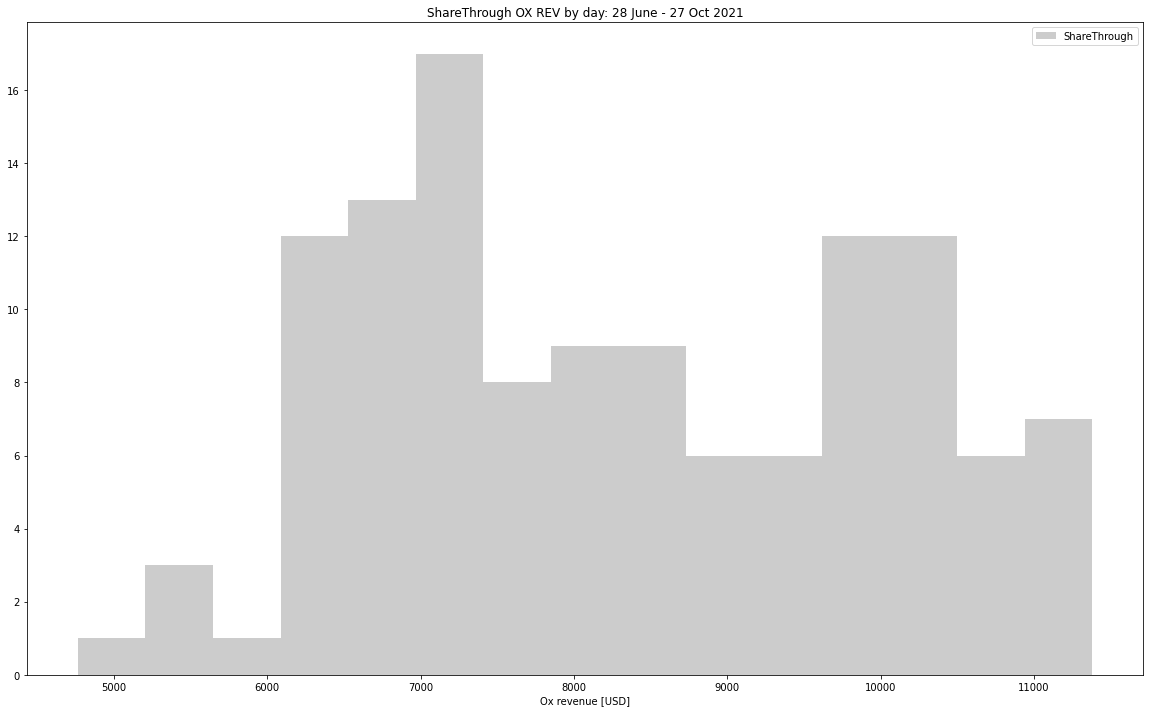

In [23]:
fig = plt.figure(figsize=(20, 12))
max_xticks = 15
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)
plt.title("Histogram ox revenue daily")

num_bins = 15

plt.xlabel("Ox revenue [USD]")

# plt.hist( df_mediavine["OX_REVENUE"],num_bins, label="Mediavine", alpha=0.4)
# plt.hist( df_yahoo["OX_REVENUE"], num_bins,label="Yahoo", color="green", alpha=0.4)
plt.hist(df_shareThrough["OX_REVENUE"], num_bins, label="ShareThrough", color="gray", alpha=0.4)

plt.legend()
plt.title("ShareThrough OX REV by day: 28 June - 27 Oct 2021")
plt.xlabel("Ox revenue [USD]")

In [24]:
daily_median = df_daily["OX_REVENUE"].median()
daily_25p, daily_75p = df_daily["OX_REVENUE"].quantile(0.25), df_daily["OX_REVENUE"].quantile(0.75)
daily_iqr = daily_75p - daily_25p
daily_lower_band = daily_25p - 1.5*daily_iqr
daily_upper_band = daily_75p + 1.5*daily_iqr

daily_median, daily_25p, daily_75p, daily_lower_band, daily_upper_band
# df_daily["OX_REVENUE"].min(), df_daily["OX_REVENUE"].max()

(302268.19369150035,
 268090.1844472504,
 328221.8121927503,
 177892.74282900055,
 418419.25381100015)

In [25]:
df_daily_outliers = df_daily[(df_daily["OX_REVENUE"]<daily_lower_band) | (df_daily["OX_REVENUE"]>daily_upper_band)]
df_daily_outliers.head()

,ReportDay,OX_REVENUE


In [26]:
df_daily['Date'] = pd.to_datetime(df_daily['ReportDay']) - pd.to_timedelta(7, unit='d')
df_weekly = df_daily.groupby([pd.Grouper(key='Date', freq='W-MON')])['OX_REVENUE'].sum().reset_index().sort_values('Date')

# df.groupby(["ReportDay"])["OX_REVENUE"].sum().reset_index()
df_daily.head(20)

,ReportDay,OX_REVENUE,Date
0,2021-06-28,334611.349557,2021-06-21
1,2021-06-29,337116.243923,2021-06-22
2,2021-06-30,318582.769268,2021-06-23
3,2021-07-01,259151.568894,2021-06-24
4,2021-07-02,253966.165114,2021-06-25
5,2021-07-03,234035.463380,2021-06-26
6,2021-07-04,234364.262035,2021-06-27
7,2021-07-05,238904.625217,2021-06-28
8,2021-07-06,246994.832101,2021-06-29
9,2021-07-07,250560.337759,2021-06-30


<ipython-input-27-d8240fef4d37>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)


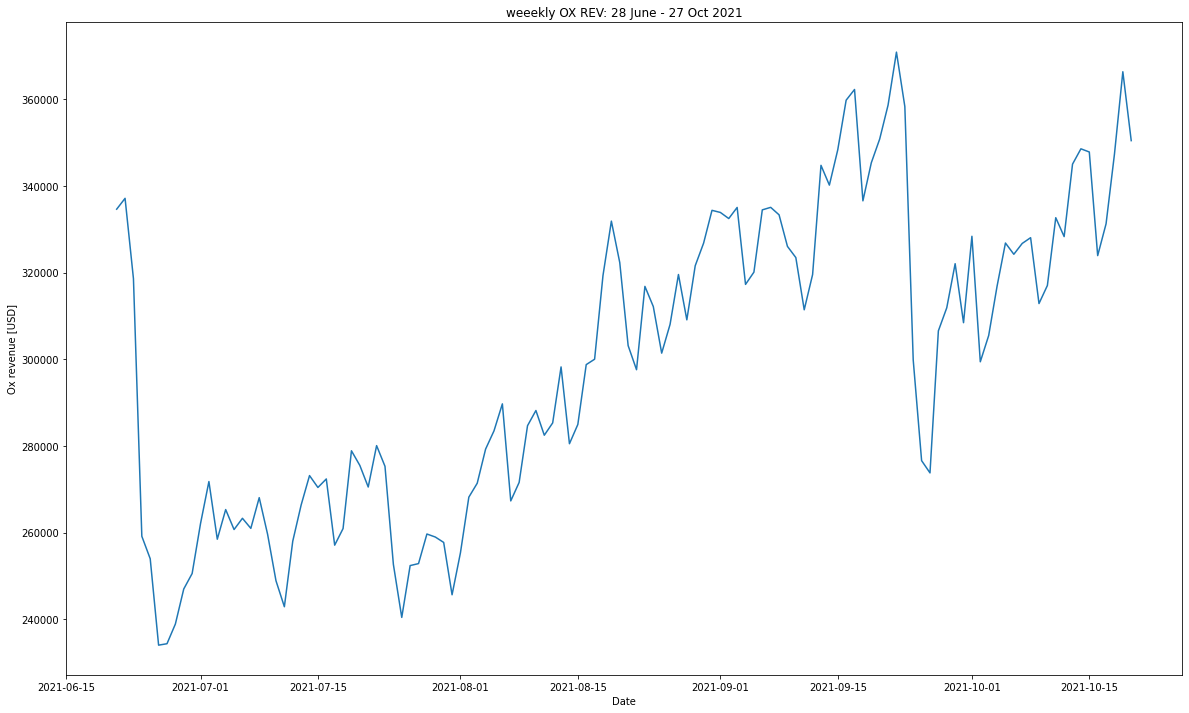

In [27]:
ig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)
max_xticks = 15
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)
plt.title("weeekly OX REV: 28 June - 27 Oct 2021")
plt.ylabel("Ox revenue [USD]")
plt.xlabel("Date")
plt.plot('Date', "OX_REVENUE", data=df_daily)

In [28]:

# df_daily = df_daily.drop(columns=["Date"])
df_daily['ox_rev_pct_change'] = df_daily["OX_REVENUE"].pct_change()*100
df_daily = df_daily.round({"ox_rev_pct_change":1})
df_daily["OX_REVENUE"] = df_daily["OX_REVENUE"].astype(int)
df_daily.head(20)

,ReportDay,OX_REVENUE,Date,ox_rev_pct_change
0,2021-06-28,334611,2021-06-21,NaN
1,2021-06-29,337116,2021-06-22,0.7
2,2021-06-30,318582,2021-06-23,-5.5
3,2021-07-01,259151,2021-06-24,-18.7
4,2021-07-02,253966,2021-06-25,-2.0
5,2021-07-03,234035,2021-06-26,-7.8
6,2021-07-04,234364,2021-06-27,0.1
7,2021-07-05,238904,2021-06-28,1.9
8,2021-07-06,246994,2021-06-29,3.4
9,2021-07-07,250560,2021-06-30,1.4


Text(-1.7179338842975211, 23.4255, 'Mean: 0.14')

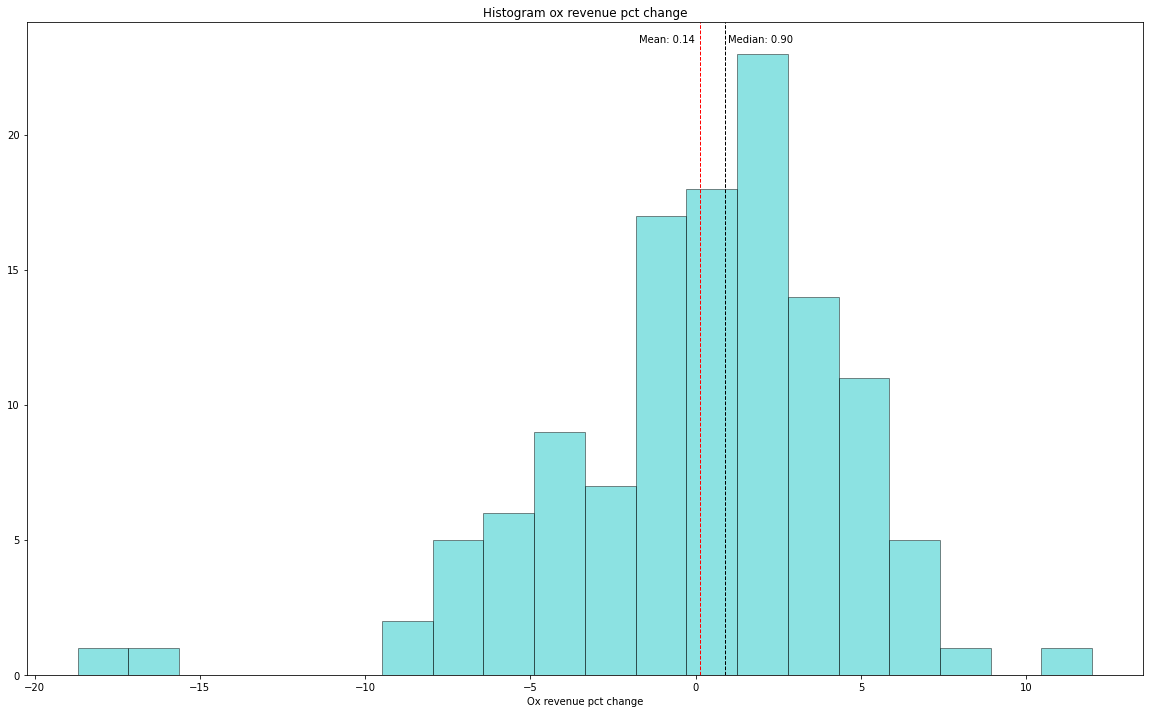

In [29]:
fig = plt.figure(figsize=(20, 12))
max_xticks = 25
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)
plt.title("Histogram ox revenue pct change")

num_bins = 15

plt.xlabel("Ox revenue pct change")
x= df_daily["ox_rev_pct_change"]
result = plt.hist(x, bins=20, color='c', edgecolor='k', alpha=0.45)
plt.axvline(x.median(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(x.mean(), color='r', linestyle='dashed', linewidth=1)
in_ylim, max_ylim = plt.ylim()
plt.text(x.median()*1.1, max_ylim*0.97, 'Median: {:.2f}'.format(x.median()))
plt.text(x.mean()*-12.3, max_ylim*0.97, 'Mean: {:.2f}'.format(x.mean()))
# plt.hist(df_daily["ox_rev_pct_change"], num_bins, alpha=0.5)

In [30]:
x.median() - 3*x.std(), x.median() + 3*x.std()

(-12.542794315478627, 14.342794315478628)

In [31]:
df_daily['ReportDay'] = pd.to_datetime(df_daily['ReportDay'])

df_daily_july = df_daily[df_daily['ReportDay'].dt.month == 7]
df_daily_august = df_daily[df_daily['ReportDay'].dt.month == 8]
df_daily_september = df_daily[df_daily['ReportDay'].dt.month == 9]

df_daily_july

,ReportDay,OX_REVENUE,Date,ox_rev_pct_change
3,2021-07-01,259151,2021-06-24,-18.7
4,2021-07-02,253966,2021-06-25,-2.0
5,2021-07-03,234035,2021-06-26,-7.8
6,2021-07-04,234364,2021-06-27,0.1
7,2021-07-05,238904,2021-06-28,1.9
8,2021-07-06,246994,2021-06-29,3.4
9,2021-07-07,250560,2021-06-30,1.4
10,2021-07-08,262085,2021-07-01,4.6
11,2021-07-09,271776,2021-07-02,3.7
12,2021-07-10,258475,2021-07-03,-4.9


Text(-2.0545161290322573, 5.0925, 'Mean: -0.62')

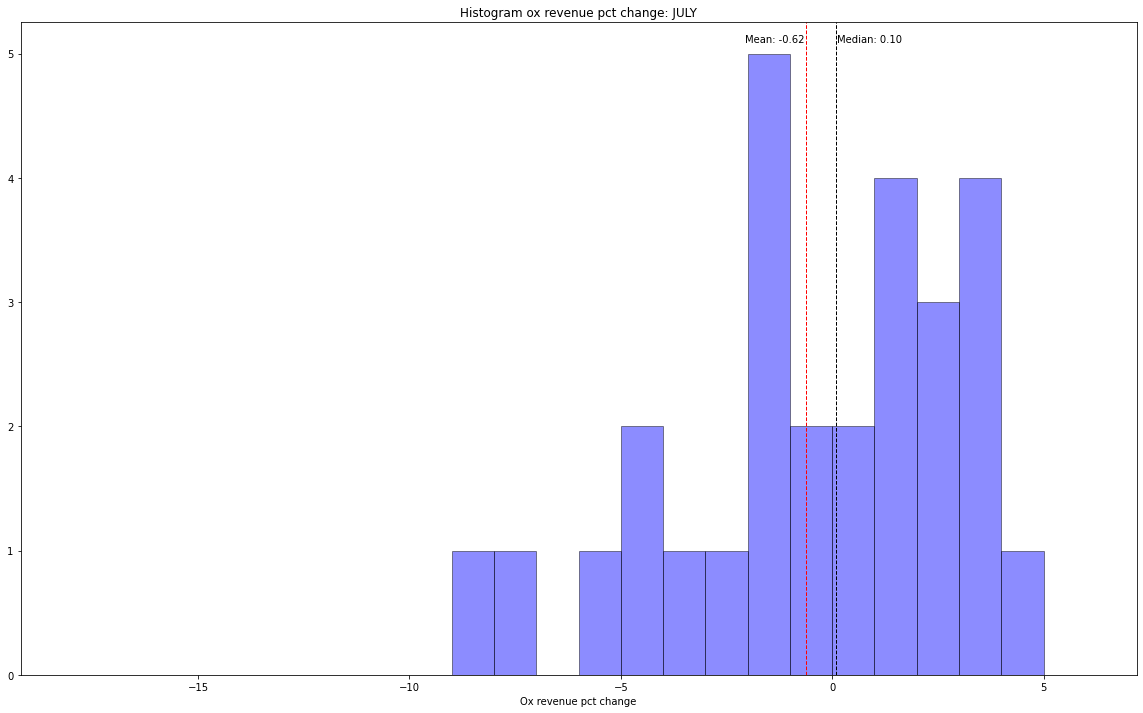

In [33]:
ig = plt.figure(figsize=(20, 12))
max_xticks = 25
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)
plt.title("Histogram ox revenue pct change: JULY")

# num_bins = 20
binwidth=1

plt.xlabel("Ox revenue pct change")
x= df_daily_july["ox_rev_pct_change"]
# result = plt.hist(x, bins=20, color='b', edgecolor='k', alpha=0.45)
result = plt.hist(x, bins=np.arange(int(min(x)), int(max(x)) + binwidth, binwidth), color='b', edgecolor='k', alpha=0.45)

plt.axvline(x.median(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(x.mean(), color='r', linestyle='dashed', linewidth=1)
in_ylim, max_ylim = plt.ylim()
plt.text(x.median()*1.1, max_ylim*0.97, 'Median: {:.2f}'.format(x.median()))
plt.text(x.mean()*3.3, max_ylim*0.97, 'Mean: {:.2f}'.format(x.mean()))

Text(-0.22548387096774192, 6.111, 'Mean: 0.75')

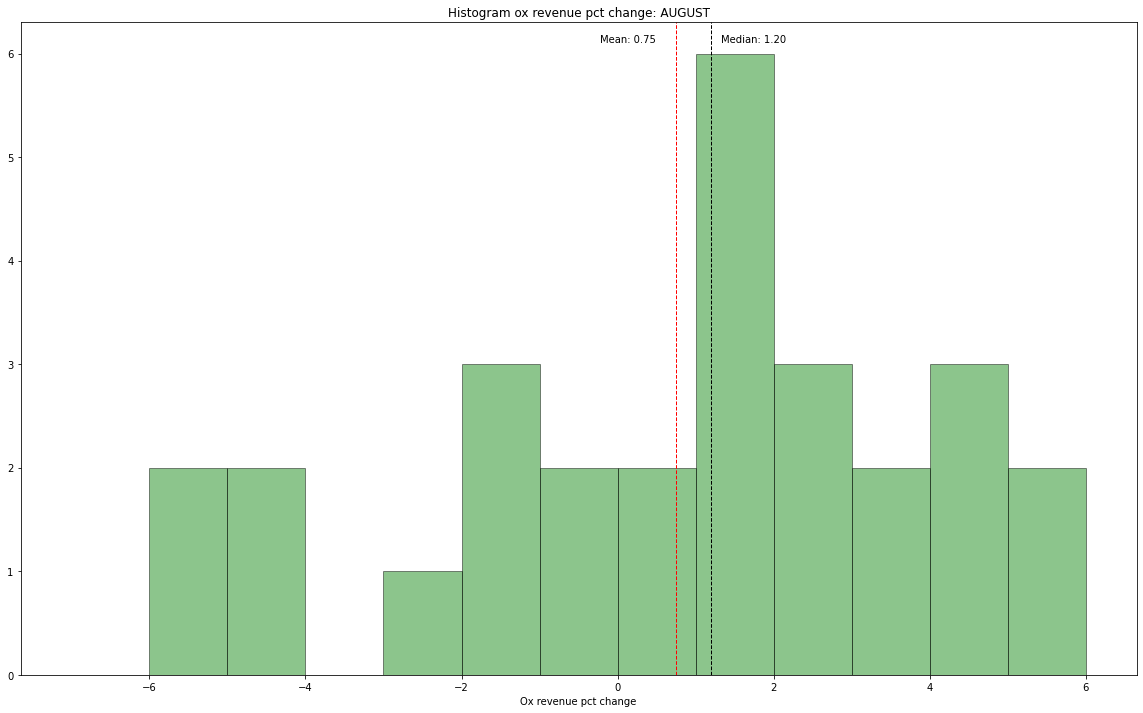

In [34]:
ig = plt.figure(figsize=(20, 12))
max_xticks = 25
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)
plt.title("Histogram ox revenue pct change: AUGUST")

# num_bins = 15
binwidth=1

plt.xlabel("Ox revenue pct change")
x= df_daily_august["ox_rev_pct_change"]
result = plt.hist(x, bins=np.arange(int(min(x)), int(max(x)) + binwidth, binwidth), color='g', edgecolor='k', alpha=0.45)
plt.axvline(x.median(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(x.mean(), color='r', linestyle='dashed', linewidth=1)
in_ylim, max_ylim = plt.ylim()
plt.text(x.median()*1.1, max_ylim*0.97, 'Median: {:.2f}'.format(x.median()))
plt.text(x.mean()*-0.3, max_ylim*0.97, 'Mean: {:.2f}'.format(x.mean()))

Text(-0.4619999999999999, 6.111, 'Mean: 0.51')

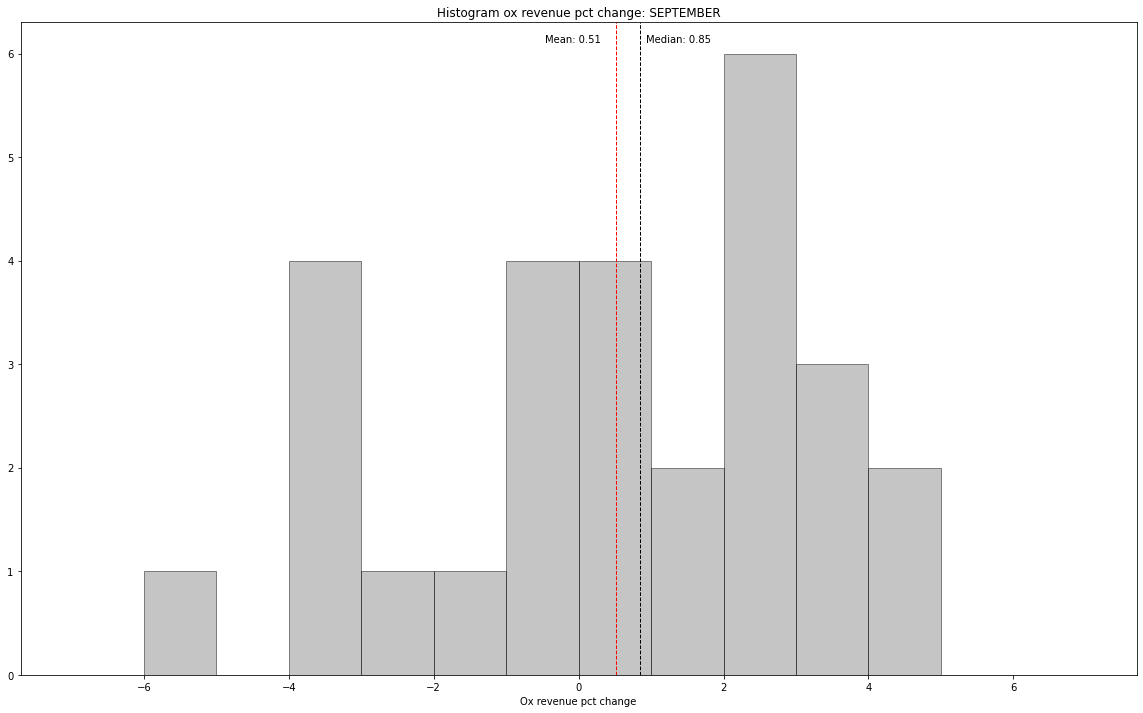

In [35]:
fig = plt.figure(figsize=(20, 12))
max_xticks = 25
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)
plt.title("Histogram ox revenue pct change: SEPTEMBER")

# num_bins = 15
binwidth=1

plt.xlabel("Ox revenue pct change")
x= df_daily_september["ox_rev_pct_change"]
result = plt.hist(x, bins=np.arange(int(min(x)), int(max(x)) + binwidth, binwidth), color='grey', edgecolor='k', alpha=0.45)
plt.axvline(x.median(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(x.mean(), color='r', linestyle='dashed', linewidth=1)
in_ylim, max_ylim = plt.ylim()
plt.text(x.median()*1.1, max_ylim*0.97, 'Median: {:.2f}'.format(x.median()))
plt.text(x.mean()*-0.9, max_ylim*0.97, 'Mean: {:.2f}'.format(x.mean()))

In [36]:
df_daily["weekday_name"] = df_daily["ReportDay"].dt.day_name()
df_daily["weekday_number"] = df_daily["ReportDay"].dt.dayofweek

df_daily.head()

,ReportDay,OX_REVENUE,Date,ox_rev_pct_change,weekday_name,weekday_number
0,2021-06-28,334611,2021-06-21,NaN,Monday,0
1,2021-06-29,337116,2021-06-22,0.7,Tuesday,1
2,2021-06-30,318582,2021-06-23,-5.5,Wednesday,2
3,2021-07-01,259151,2021-06-24,-18.7,Thursday,3
4,2021-07-02,253966,2021-06-25,-2.0,Friday,4


<AxesSubplot:title={'center':'Ox_pct change by weekday'}, xlabel='weekday_name', ylabel='ox_rev_pct_change'>

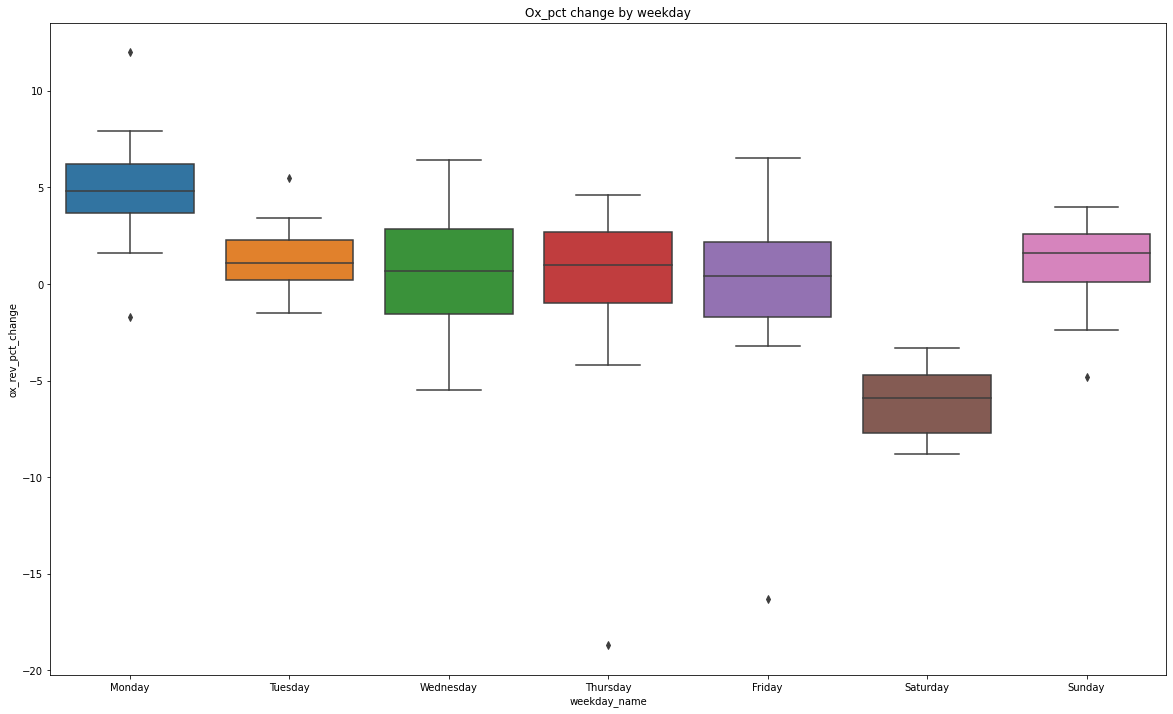

In [37]:
fig, ax = plt.subplots(figsize=(20, 12))
plt.title("Ox_pct change by weekday")
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# sns.boxplot(column=['ox_rev_pct_change'], by='weekday_name', ax=ax, order=order)
sns.boxplot(data=df_daily, x='weekday_name', y='ox_rev_pct_change', order=order)

In [39]:
def ABC_analysis(df):
    grouped_df = (
            df.loc[:, ['SF_name','OX_REVENUE']]
            .groupby('SF_name')
            .sum()         
        )

    grouped_df = grouped_df.sort_values(by=['OX_REVENUE'], ascending=False)
    
    ## Ranking by importance
    grouped_df["Rank"] = grouped_df['OX_REVENUE'].rank(ascending = False)
    grouped_df["Importance"] = ' '
    grouped_df = grouped_df.reset_index()

    ## Checking the Importance of the Customers and Categorising into class A,B,C and splitting based on 20-30-50
    grouped_df['Importance'][0: int(0.2 * grouped_df['Rank'].max())] = 'A'
    grouped_df['Importance'][int(0.2 * grouped_df['Rank'].max()) : int(0.5 * grouped_df['Rank'].max())] = 'B'
    grouped_df['Importance'][int(0.5 * grouped_df['Rank'].max()): ] = 'C'                  
    
    return grouped_df

In [40]:
ABC_groups = ABC_analysis(df)
ABC_groups.head()

<ipython-input-39-77d8678064ca>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df['Importance'][0: int(0.2 * grouped_df['Rank'].max())] = 'A'
<ipython-input-39-77d8678064ca>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df['Importance'][int(0.2 * grouped_df['Rank'].max()) : int(0.5 * grouped_df['Rank'].max())] = 'B'
<ipython-input-39-77d8678064ca>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df['Impo

,SF_name,OX_REVENUE,Rank,Importance
0,Yahoo,2.152280e+06,1.0,A
1,Mediavine,1.326760e+06,2.0,A
2,ShareThrough,1.018215e+06,3.0,A
3,Pluto TV,9.453127e+05,4.0,A
4,Primis,9.185304e+05,5.0,A


In [41]:
def XYZ_analysis(df):
    XYZ_list = []
    for group, value in df.groupby(['SF_name']):
        grouped_df = (
                value.loc[:, ['Timeperiod','Quantity']].set_index('Timeperiod')      
        )

        # Using a simple Seasonal ARIMA model to highlight the idea, in the actual world, the model has to best fit the data
        train, test = train_test_split(grouped_df, train_size=18)

        model = pm.auto_arima(train, seasonal=True, m=4)

        forecasts = model.predict(test.shape[0])  # predict N steps into the future
        mape = MAPE(test.values.reshape(1,-1)[0], forecasts)
        XYZ_list.append([group, mape])
     
    XYZ_group = pd.DataFrame(XYZ_list, columns = ['SF_name', 'MAPE'])
    XYZ_group = XYZ_group.sort_values(by=['MAPE'], ascending=True)
    
    ## Ranking by forecastability
    XYZ_group["Rank"] = XYZ_group['MAPE'].rank(ascending = True)
    XYZ_group["Forecastability"] = ' '
    
    ## Checking the Importance of the Customers and Categorising   into class A,B,C and splitting based on 20-30-50
    XYZ_group['Forecastability'][0: int(0.2 * XYZ_group['Rank'].max())] = 'X'
    XYZ_group['Forecastability'][int(0.2 * XYZ_group['Rank'].max()) : int(0.5 * XYZ_group['Rank'].max())] = 'Y'
    XYZ_group['Forecastability'][int(0.5 * XYZ_group['Rank'].max()): ] = 'Z'
    
    return XYZ_group

In [42]:
def MAPE(y_orig, y_pred):
    diff = y_orig - y_pred
    MAPE = np.mean((abs(y_orig - y_pred)/y_orig)  * 100.)
    return MAPE

In [44]:
# XYZ_groups = XYZ_analysis(df)
# XYZ_groups.head()

In [53]:
df_null = df[df["OX_REVENUE"].isnull()]
# df["OX_REVENUE"].isnull().sum()

df.update(df[['OX_REVENUE','MKT_DEM_SPEND_USD','MKT_PUB_REV_USD', 'MKT_REQUESTS', 'FILLS', 'MKT_IMPRESSIONS']].fillna(0))
df_null = df[df["OX_REVENUE"].isnull()]
df_null.head(10)

,ReportDay,SF_name,IS_NEW_PUB,MKT_DEM_SPEND_USD,MKT_PUB_REV_USD,OX_REVENUE,TOTAL_REQUESTS,MKT_REQUESTS,FILLS,MKT_IMPRESSIONS


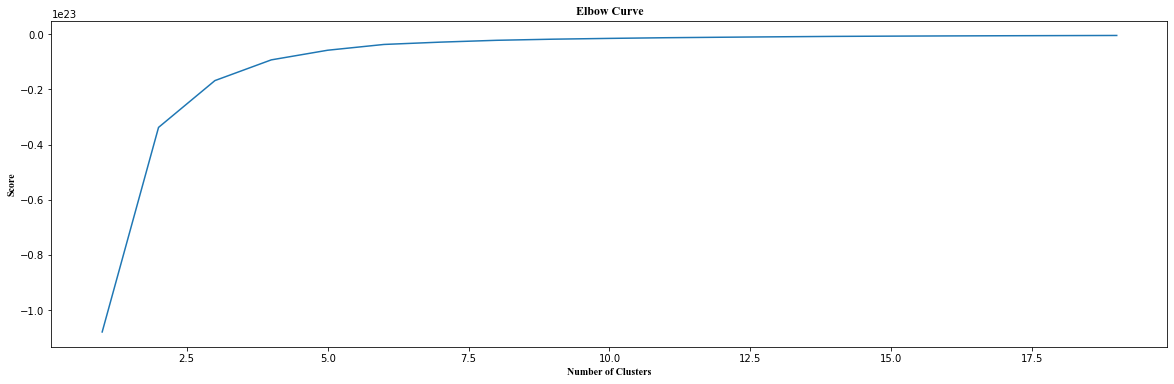

In [71]:

data = df[['OX_REVENUE', 'TOTAL_REQUESTS']]
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters', fontname="Times New Roman",fontweight="bold")
plt.ylabel('Score',fontname="Times New Roman",fontweight="bold")
plt.title("Elbow Curve",fontname="Times New Roman",fontweight="bold")
plt.show();

IndexError: single positional indexer is out-of-bounds

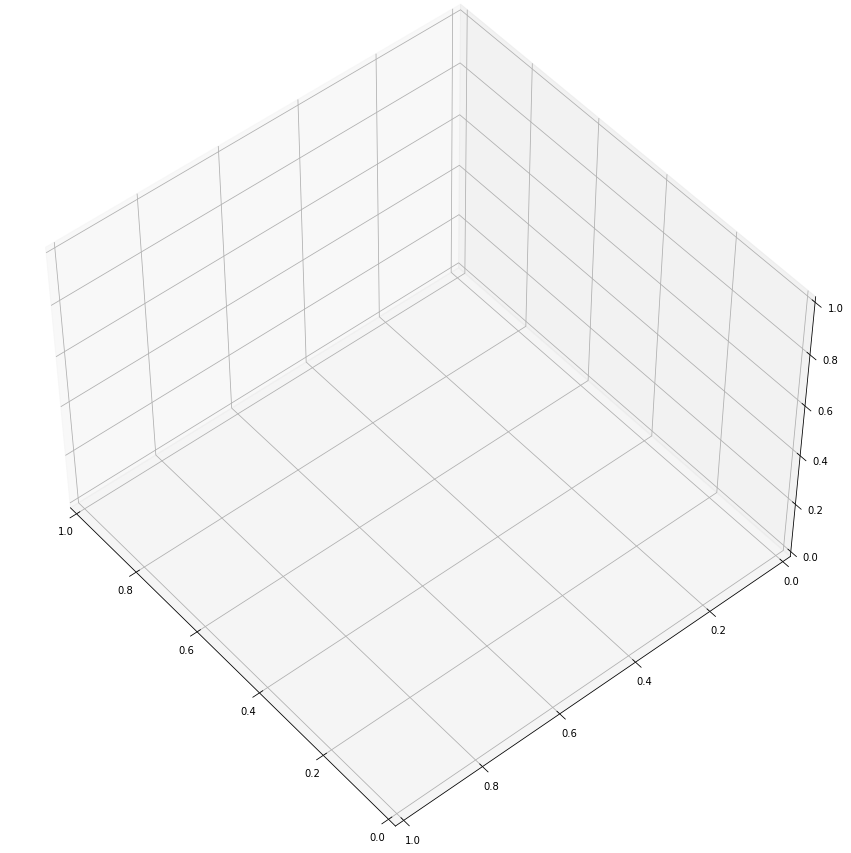

In [72]:
X = df[['OX_REVENUE', 'TOTAL_REQUESTS']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=7)
km.fit(X)
km.predict(X)
labels = km.labels_
#Plotting
fig = plt.figure(1, figsize=(12,12))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=49, azim=140)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], c=labels.astype(np.float), edgecolor="r")
ax.set_xlabel("OX_REVENUE")
ax.set_ylabel("TOTAL_REQUESTS")
plt.title("K Means Clustering for Anomaly Detection", fontsize=20, fontweight="bold");

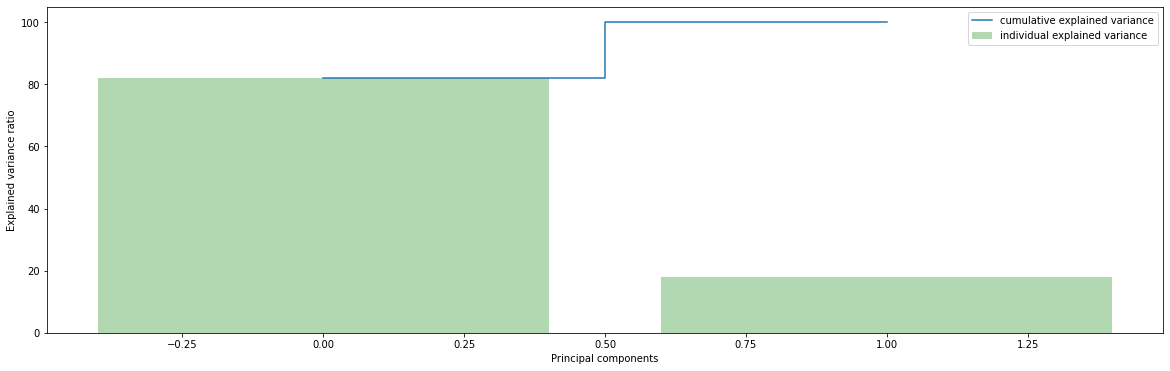

In [73]:
data = df[['OX_REVENUE', 'TOTAL_REQUESTS']]
X = data.values
X_std = StandardScaler().fit_transform(X)
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(20, 6))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

In [74]:
data = df[['OX_REVENUE', 'TOTAL_REQUESTS']]
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)
# reduce to 2 important features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [75]:
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
df['cluster'] = kmeans[7].predict(data)
df.index = data.index
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

0    159269
7      9164
6      2290
4       926
1       650
5       504
3       140
2        90
Name: cluster, dtype: int64

In [76]:
df.head(10)

,ReportDay,SF_name,IS_NEW_PUB,MKT_DEM_SPEND_USD,MKT_PUB_REV_USD,OX_REVENUE,TOTAL_REQUESTS,MKT_REQUESTS,FILLS,MKT_IMPRESSIONS,cluster,principal_feature1,principal_feature2
0,2021-06-28,Automatad,False,672.562712,490.360576,182.202136,110839218,62063383.0,12157056.0,405852.0,0,-0.054015,-0.034633
1,2021-06-28,Mind Tank Media,False,1070.386924,846.429989,223.956935,75376144,55641408.0,17629858.0,357401.0,0,-0.051551,-0.146014
2,2021-06-28,Discovery NZ (Previously Mediaworks),False,26.216096,22.270789,3.945307,1687567,1269502.0,133579.0,18578.0,0,-0.246539,0.051092
3,2021-06-28,United Online,False,867.309795,730.130310,137.179485,54361360,45836959.0,14674546.0,1299466.0,0,-0.122835,-0.056229
4,2021-06-28,Barstool Sports,False,2.741228,2.129037,0.612191,7934723,7192490.0,1740494.0,168.0,0,-0.244350,0.065094
5,2021-06-28,Slacker,False,152.315667,122.906834,29.408833,4525016,3819203.0,2338799.0,48248.0,0,-0.227947,0.019766
6,2021-06-28,Loadcomplete,False,0.000000,0.000000,0.000000,605,324.0,163.0,0.0,0,-0.250291,0.054080
7,2021-06-28,Triple13,False,330.289948,246.843391,83.446557,20823011,16373734.0,5361994.0,131895.0,0,-0.181314,-0.031340
8,2021-06-28,Infolinks,False,1072.357311,847.336940,225.020371,77705660,68595204.0,37960609.0,710332.0,0,-0.049230,-0.144015
9,2021-06-28,Re,False,5.150927,3.875526,1.275401,1064431,873829.0,295890.0,6751.0,0,-0.248716,0.053890


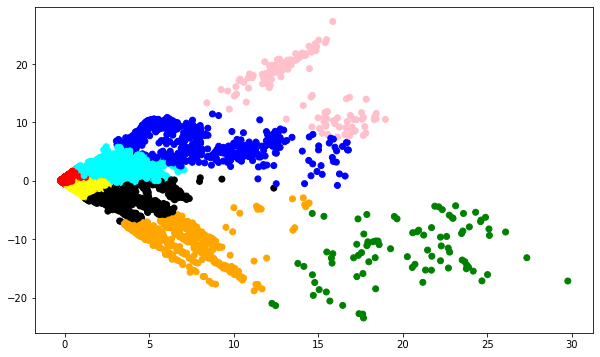

In [77]:
# plot the different clusters with the 2 main features
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show();

In [81]:
# return Series of distance between each point and its distance with the closest centroid
import sys
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[7])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly1'] = (distance >= threshold).astype(int)

<ipython-input-81-21c2a6144bbb>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  distance = pd.Series()


In [82]:
df.anomaly1.value_counts()

0    171303
1      1730
Name: anomaly1, dtype: int64

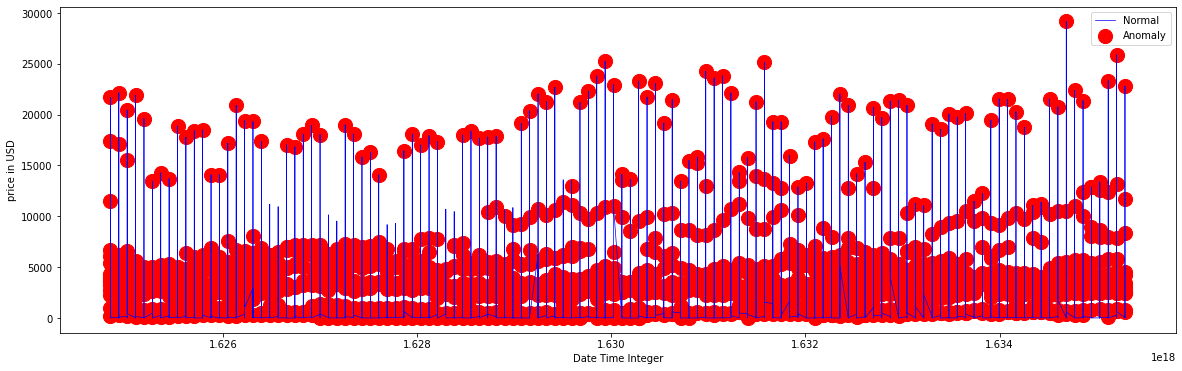

In [84]:
df = df.sort_values('ReportDay')
df["date_time"] = pd.to_datetime(df["ReportDay"])
df['date_time_int'] = df.date_time.astype(np.int64)
fig, ax = plt.subplots(figsize=(20,6))

a = df.loc[df['anomaly1'] == 1, ['date_time_int', 'OX_REVENUE']] #anomaly

ax.scatter(a['date_time_int'],a['OX_REVENUE'], color='red', label='Anomaly',s = 200)
ax.plot(df['date_time_int'], df['OX_REVENUE'], color='blue', label='Normal',linewidth=0.7)
plt.xlabel('Date Time Integer')
plt.ylabel('price in USD')
plt.legend()
plt.show();

<ipython-input-100-466eaf215f68>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_daily = df.groupby(["ReportDay"])["OX_REVENUE", 'TOTAL_REQUESTS', 'IS_NEW_PUB'].sum().reset_index()


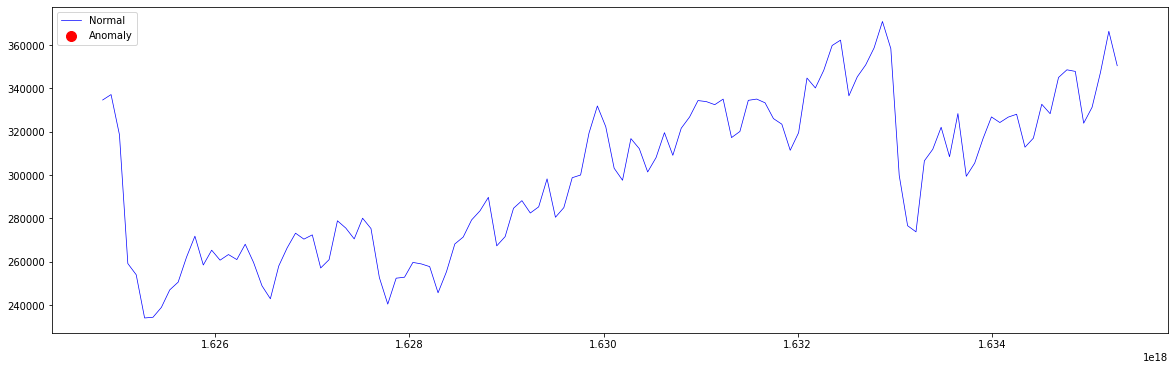

In [100]:
df_daily = df.groupby(["ReportDay"])["OX_REVENUE", 'TOTAL_REQUESTS', 'IS_NEW_PUB'].sum().reset_index()
df_daily.head()
data = df_daily[['OX_REVENUE', 'TOTAL_REQUESTS']]
df_daily["date_time"] = pd.to_datetime(df_daily["ReportDay"])
df_daily['date_time_int'] = df_daily.date_time.astype(np.int64)
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train oneclassSVM 
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(data)

 
df_daily['anomaly3'] = pd.Series(model.predict(data))
# df['anomaly3'] = df['anomaly3'].map( {1: 0, -1: 1} )
fig, ax = plt.subplots(figsize=(20,6))

a = df_daily.loc[df['anomaly3'] == -1, ['date_time_int', 'OX_REVENUE']] #anomaly

ax.plot(df_daily['date_time_int'], df_daily['OX_REVENUE'], color='blue', label ='Normal', linewidth = 0.7)
ax.scatter(a['date_time_int'],a['OX_REVENUE'], color='red', label = 'Anomaly', s = 100)
plt.legend()
plt.show();

Text(0.5, 1.0, 'NEW_PUB')

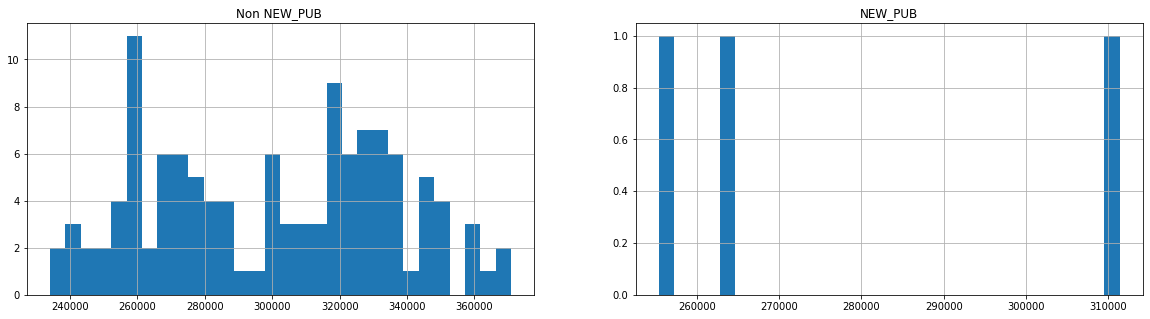

In [102]:
df_class0 = df_daily.loc[df['IS_NEW_PUB'] == 0, 'OX_REVENUE']
df_class1 = df_daily.loc[df['IS_NEW_PUB'] == 1, 'OX_REVENUE']

fig, axs = plt.subplots(1,2, figsize= (20,5))
df_class0.hist(ax=axs[0], bins=30)
df_class1.hist(ax=axs[1], bins=30)
axs[0].set_title("Non NEW_PUB ")
axs[1].set_title("NEW_PUB")

In [103]:
from sklearn.covariance import EllipticEnvelope

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)


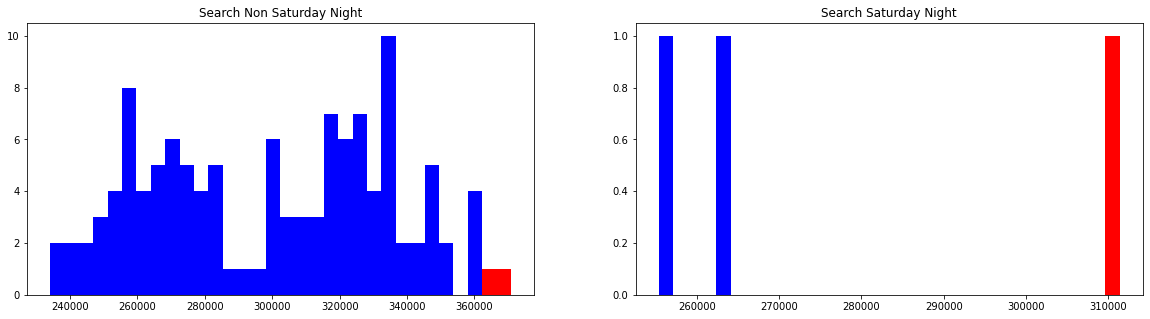

In [104]:
# plot the price repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'OX_REVENUE']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'OX_REVENUE']

a2 = df_class1.loc[df_class1['anomaly'] == 1, 'OX_REVENUE']
b2 = df_class1.loc[df_class1['anomaly'] == -1, 'OX_REVENUE']

fig, axs = plt.subplots(1,2, figsize= (20,5))
axs[0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'])
axs[1].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'])
axs[0].set_title("Search Non Saturday Night")
axs[1].set_title("Search Saturday Night")
plt.show();

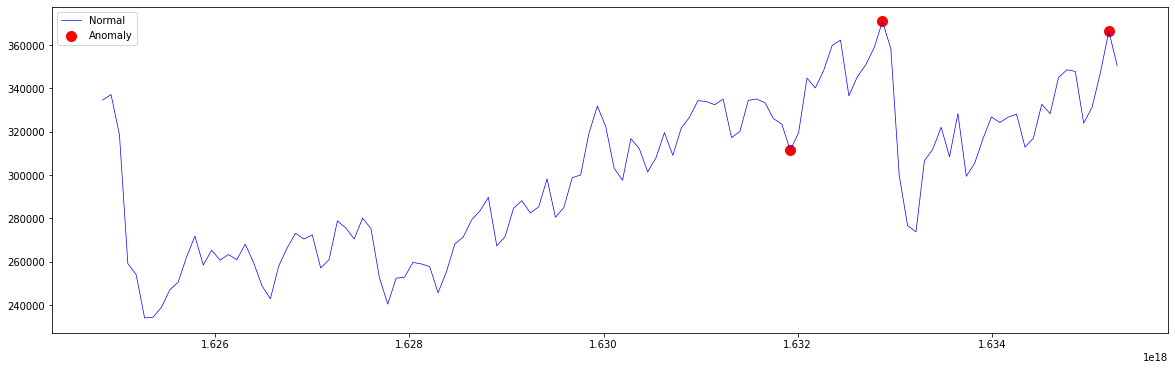

In [105]:
# add the data to the main 
df_class = pd.concat([df_class0, df_class1])
df_daily['anomaly5'] = df_class['anomaly']

df_daily["date_time"] = pd.to_datetime(df_daily["ReportDay"])
df_daily['date_time_int'] = df_daily.date_time.astype(np.int64)
# df['anomaly5'] = np.array(df['anomaly22'] == -1).astype(int)
fig, ax = plt.subplots(figsize=(20, 6))
a = df_daily.loc[df_daily['anomaly5'] == -1, ('date_time_int', 'OX_REVENUE')] #anomaly
ax.plot(df_daily['date_time_int'], df_daily['OX_REVENUE'], color='blue', label='Normal', linewidth = 0.7)
ax.scatter(a['date_time_int'],a['OX_REVENUE'], color='red', label='Anomaly', s = 100)
plt.legend()
plt.show();

In [106]:
df_daily.head()

,ReportDay,OX_REVENUE,TOTAL_REQUESTS,IS_NEW_PUB,date_time,date_time_int,anomaly3,anomaly5
0,2021-06-28,334611.349557,210935363982,39,2021-06-28,1624838400000000000,1,1
1,2021-06-29,337116.243923,210669268525,39,2021-06-29,1624924800000000000,1,1
2,2021-06-30,318582.769268,209563306516,39,2021-06-30,1625011200000000000,1,1
3,2021-07-01,259151.568894,210303161207,40,2021-07-01,1625097600000000000,1,1
4,2021-07-02,253966.165114,201841772024,40,2021-07-02,1625184000000000000,1,1


In [120]:
df_daily = df.groupby(["ReportDay"])["OX_REVENUE", 'TOTAL_REQUESTS', 'MKT_DEM_SPEND_USD','MKT_PUB_REV_USD', 'MKT_REQUESTS', 'FILLS', 'MKT_IMPRESSIONS'].sum().reset_index()
df_daily.head()

<ipython-input-120-14809095fa0e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_daily = df.groupby(["ReportDay"])["OX_REVENUE", 'TOTAL_REQUESTS', 'MKT_DEM_SPEND_USD','MKT_PUB_REV_USD', 'MKT_REQUESTS', 'FILLS', 'MKT_IMPRESSIONS'].sum().reset_index()


,ReportDay,OX_REVENUE,TOTAL_REQUESTS,MKT_DEM_SPEND_USD,MKT_PUB_REV_USD,MKT_REQUESTS,FILLS,MKT_IMPRESSIONS
0,2021-06-28,334611.349557,210935363982,1.859601e+06,1.524989e+06,1.303949e+11,2.122407e+10,995640207.0
1,2021-06-29,337116.243923,210669268525,1.853779e+06,1.516663e+06,1.347097e+11,2.074806e+10,972284903.0
2,2021-06-30,318582.769268,209563306516,1.754068e+06,1.435486e+06,1.353417e+11,1.931724e+10,913916476.0
3,2021-07-01,259151.568894,210303161207,1.408858e+06,1.149707e+06,1.341827e+11,1.666830e+10,840439373.0
4,2021-07-02,253966.165114,201841772024,1.414687e+06,1.160721e+06,1.276483e+11,1.693661e+10,833241503.0


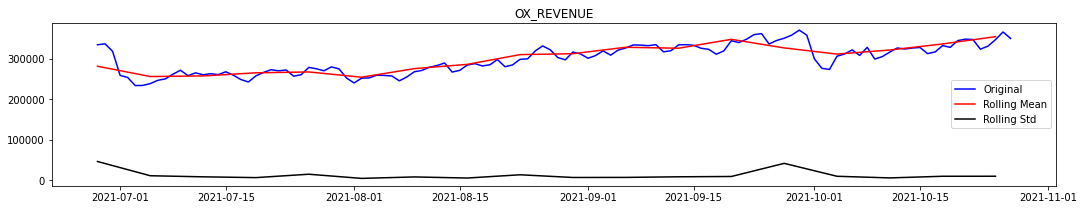

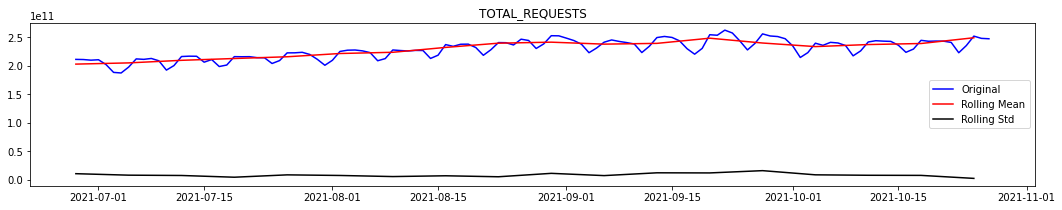

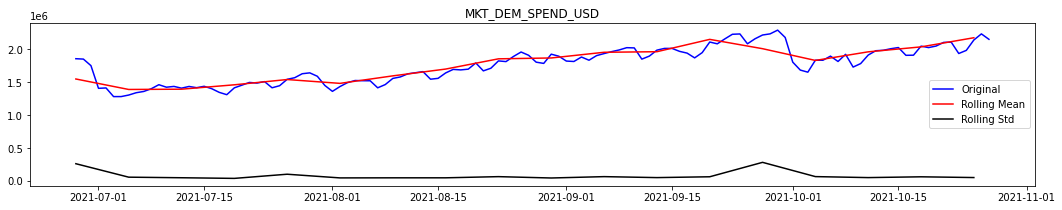

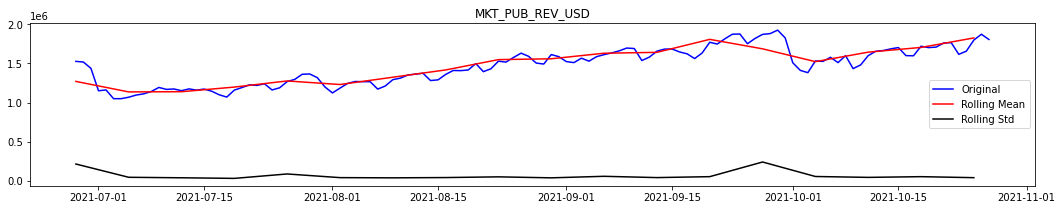

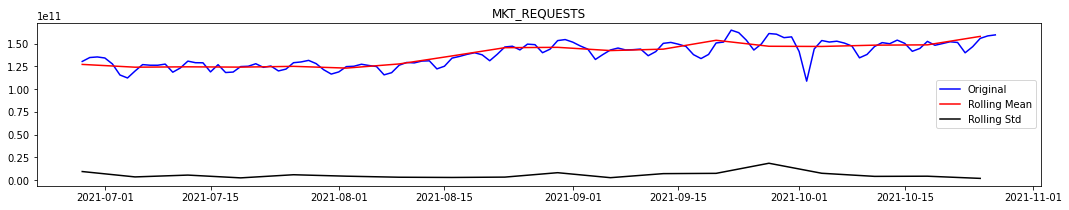

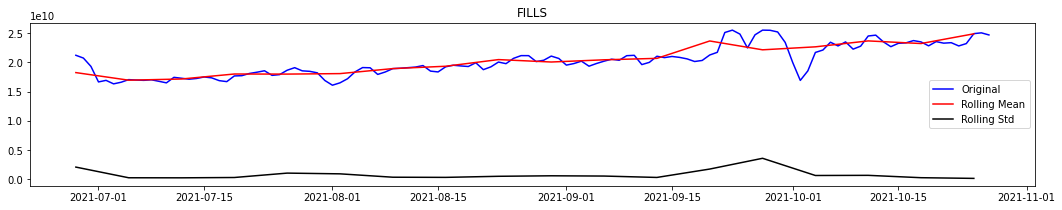

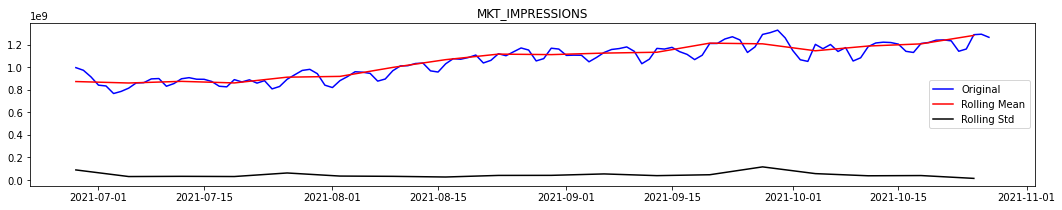

In [134]:
# Resample the entire dataset by daily average
df_daily['ReportDay'] = pd.to_datetime(df_daily['ReportDay'])
df_test = df_daily[['ReportDay', 'OX_REVENUE', 'TOTAL_REQUESTS', 'MKT_DEM_SPEND_USD','MKT_PUB_REV_USD', 'MKT_REQUESTS', 'FILLS', 'MKT_IMPRESSIONS']]
df_test = df_test.set_index('ReportDay')
df_test.head()
rollmean = df_test.resample(rule='7D').mean()
rollstd = df_test.resample(rule='7D').std()

# Plot time series for each sensor with its mean and standard deviation
names = ["OX_REVENUE", 'TOTAL_REQUESTS', 'MKT_DEM_SPEND_USD','MKT_PUB_REV_USD', 'MKT_REQUESTS', 'FILLS', 'MKT_IMPRESSIONS'] 
for name in names:
    _ = plt.figure(figsize=(18,3))
    _ = plt.plot(df_test[name], color='blue', label='Original')
    _ = plt.plot(rollmean[name], color='red', label='Rolling Mean')
    _ = plt.plot(rollstd[name], color='black', label='Rolling Std' )
    _ = plt.legend(loc='best')
    _ = plt.title(name)
    plt.show()

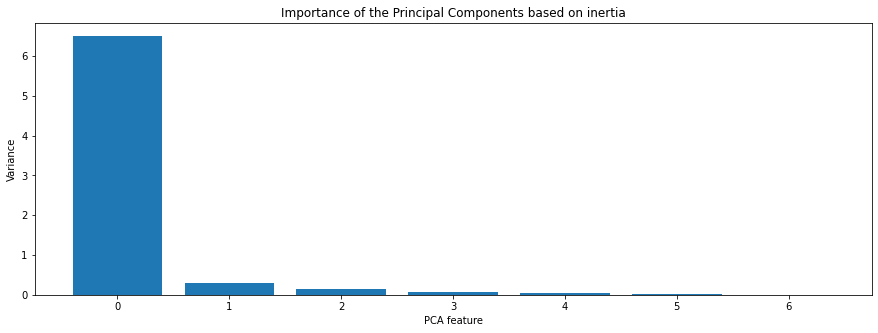

In [123]:
# Standardize/scale the dataset and apply PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
# Extract the names of the numerical columns
df2 = df_daily.drop(['ReportDay'], axis=1)
names=df2.columns
x = df_daily[names]
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(x)
# Plot the principal components against their inertia
features = range(pca.n_components_)
_ = plt.figure(figsize=(15, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title("Importance of the Principal Components based on inertia")
plt.show()

In [124]:
# Calculate PCA with 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

In [127]:
!pip install statsmodels

In [129]:
import statsmodels
from statsmodels.tsa.stattools import adfuller
# Run Augmented Dickey Fuller Test
result = adfuller(principalDf['pc1'])
# Print p-value
print(result[1])

ModuleNotFoundError: No module named 'statsmodels'

In [130]:
# Calculate IQR for the 1st principal component (pc1)
q1_pc1, q3_pc1 = df['pc1'].quantile([0.25, 0.75])
iqr_pc1 = q3_pc1 - q1_pc1
# Calculate upper and lower bounds for outlier for pc1
lower_pc1 = q1_pc1 - (1.5*iqr_pc1)
upper_pc1 = q3_pc1 + (1.5*iqr_pc1)
# Filter out the outliers from the pc1
df['anomaly_pc1'] = ((df['pc1']>upper_pc1) | (df['pc1']<lower_pc1)).astype('int')
# Calculate IQR for the 2nd principal component (pc2)
q1_pc2, q3_pc2 = df['pc2'].quantile([0.25, 0.75])
iqr_pc2 = q3_pc2 - q1_pc2
# Calculate upper and lower bounds for outlier for pc2
lower_pc2 = q1_pc2 - (1.5*iqr_pc2)
upper_pc2 = q3_pc2 + (1.5*iqr_pc2)
# Filter out the outliers from the pc2
df['anomaly_pc2'] = ((df['pc2']>upper_pc2) | (df['pc2']<lower_pc2)).astype('int')
# Let's plot the outliers from pc1 on top of the sensor_11 and see where they occured in the time series
a = df[df['anomaly_pc1'] == 1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df['sensor_11'], color='blue', label='Normal')
_ = plt.plot(a['sensor_11'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor_11 Anomalies')
_ = plt.legend(loc='best')
plt.show();


KeyError: 'pc1'

In [132]:
# Import necessary libraries
from sklearn.cluster import KMeans
# I will start k-means clustering with k=2 as I already know that there are 3 classes of "NORMAL" vs 
# "NOT NORMAL" which are combination of BROKEN" and"RECOVERING"
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(principalDf.values)
labels = kmeans.predict(principalDf.values)
unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))
# Write a function that calculates distance between each point and the centroid of the closest cluster
def getDistanceByPoint(data, model):
    """ Function that calculates the distance between a point and centroid of a cluster, 
            returns the distances in pandas series"""
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)
# Assume that 13% of the entire data set are anomalies 
outliers_fraction = 0.13
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(principalDf, kmeans)
# number of observations that equate to the 13% of the entire data set
number_of_outliers = int(outliers_fraction*len(distance))
# Take the minimum of the largest 13% of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
principalDf['anomaly1'] = (distance >= threshold).astype(int)

In [133]:
# Import IsolationForest
from sklearn.ensemble import IsolationForest
# Assume that 13% of the entire data set are anomalies
 
outliers_fraction = 0.13
model =  IsolationForest(contamination=outliers_fraction)
model.fit(principalDf.values) 
principalDf['anomaly2'] = pd.Series(model.predict(principalDf.values))
# visualization
df['anomaly2'] = pd.Series(principalDf['anomaly2'].values, index=df.index)
a = df.loc[df['anomaly2'] == -1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df['sensor_11'], color='blue', label='Normal')
_ = plt.plot(a['sensor_11'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor_11 Anomalies')
_ = plt.legend(loc='best')
plt.show();

ValueError: Length of passed values is 122, index implies 173033.

In [3]:
!pip3 install statsmodels


In [5]:
import statsmodels

ModuleNotFoundError: No module named 'statsmodels'